In [1]:
import os
import sys
import time
import numpy as np
import psi4
import numpy as np
from tqdm import tqdm

In [2]:
def RL(A, k, mode='rl', learning_rate=0.5, discount=0.99, max_episode=30,
       max_pick=None,silent=False,ex=0):
    NDIM = len(A)
    if max_pick is None:
        max_pick = NDIM - k
    if mode == 'rl':
        E, idx = RL(A, k, mode='greedy')
        state = np.zeros((NDIM), dtype=np.int64)
        state[idx] = 1  # set topk rows from initialization to "active"
        active = np.argwhere(state == 1).reshape(-1,)
        inactive = np.argwhere(state == 0).reshape(-1,)
        assert len(active) == k
        assert len(inactive) == NDIM - k
        E, C = np.linalg.eigh(A[np.ix_(active, active)])
        E0, C0 = E[0], C[:, 0]
        E_best, state_best = E0, active
        w = np.zeros((NDIM))
        w[active] = np.abs(C0)  # from initial guess
        w[active] /= np.linalg.norm(w[active])  # normalize
        w[inactive] = perturb(A, state)  # PT guess at weights
        w[inactive] /= np.linalg.norm(w[inactive])  # normalize
        v = np.zeros_like(w)  # auxilliary weights
        if not silent:
            progress_bar = tqdm(range(max_episode))  # keep track of progress
        else:
            progress_bar = range(max_episode)  
        for episode in progress_bar:
            if not silent:
                progress_bar.set_description("Best energy: %.6f" % E_best)
            explore_rate = np.exp(-learning_rate*(episode+1))
            state *= 0
            if np.random.rand(1) < 0.75:
                active = np.argsort(w)[::-1][:k].reshape(-1,)
            else:
                active = state_best
            state[active] = 1
            inactive = np.argwhere(state == 0).reshape(-1,)
            E, C = np.linalg.eigh(A[np.ix_(active, active)])
            E0, C0 = E[0], C[:, 0]
            if E0 < E_best:
                E_best = E0
                state_best = active
            active_idx_sorted = np.argsort(w[active])  # sort asc
            selected = np.arange(len(w))[active][active_idx_sorted]
            cj = perturb(A, state)  # PT guess at weights
            inact_idx_sort = np.argsort(np.abs(cj))[::-1]  # desc
            expanded = np.arange(len(w))[inactive][inact_idx_sort][:max_pick]
            total_replaced = 0
            for j in range(max_pick):
                assert sum(state) == k  # make sure we have consistent # row
                is_replaced = False
                state[expanded[j]] = 1
                for i in range(k):
                    state[selected[i]] = 0
                    active = np.argwhere(state == 1).reshape(-1,)
                    inactive = np.argwhere(state == 0).reshape(-1,)
                    assert len(active) == k
                    assert len(inactive) == NDIM - k
                    E, C = np.linalg.eigh(A[np.ix_(active, active)])
                    Enew, Cnew = E[0], C[:, 0]
                    if Enew < E0 * (1 - explore_rate*np.random.rand(1)):
                        is_replaced = True
                        total_replaced += 1
                        state1 = np.zeros_like(state)
                        state1[selected] = 1
                        p = selected[i]
                        q = expanded[j]
                        sele1, sele2 = np.split(selected, [i])
                        selected = np.concatenate((sele1,
                                                   sele2[1:],
                                                   [expanded[j]]))
                        state2 = np.zeros_like(state)
                        state2[selected] = 1
                        active = np.argwhere(state2 == 1).reshape(-1,)
                        inactive = np.argwhere(state2 == 0).reshape(-1,)
                        R = E0 - Enew
                        if Enew < E_best:
                            E_best = Enew
                            state_best = active
                        E0 = Enew
                        C0 = Cnew
                        pp = np.arange(len(w))[active][np.argmin(w[active])]
                        qp = np.arange(len(w))[inactive][np.argmax(w[inactive])]
                        assert w[pp] == min(w[active])
                        assert w[qp] == max(w[inactive])
                        assert p not in active
                        delta = R + discount*np.dot(w,f(state2,(pp,qp))) - np.dot(w,f(state1,(p,q)))
                        aux = np.dot(f(state1,(p,q)),v) 
                        w += learning_rate *\
                             (delta*f(state1,(p,q)) - discount*aux*f(state2,(pp,qp)))
                        beta = np.sqrt(learning_rate) 
                        v += beta*(delta - aux)*f(state1,(p,q))
                        break
                    state[selected[i]] = 1
                if is_replaced is False:
                    state[expanded[j]] = 0

            if total_replaced == 0:
                break

        return E_best, state_best
    if mode == 'rle':
        E, idx = RL(A, k, mode='greedy')
        state = np.zeros((NDIM), dtype=np.int64)
        state[idx] = 1  # set topk rows from initialization to "active"
        active = np.argwhere(state == 1).reshape(-1,)
        inactive = np.argwhere(state == 0).reshape(-1,)
        assert len(active) == k
        assert len(inactive) == NDIM - k
        E, C = np.linalg.eigh(A[np.ix_(active, active)])
        E0, C0 = E[2], C[:, 2]
        E_best, state_best = E0, active
        w = np.zeros((NDIM))
        w[active] = np.abs(C0)  # from initial guess
        w[active] /= np.linalg.norm(w[active])  # normalize
        w[inactive] = perturb(A, state)  # PT guess at weights
        w[inactive] /= np.linalg.norm(w[inactive])  # normalize
        v = np.zeros_like(w)  # auxilliary weights
        if not silent:
            progress_bar = tqdm(range(max_episode))  # keep track of progress
        else:
            progress_bar = range(max_episode)  
        for episode in progress_bar:
            if not silent:
                progress_bar.set_description("Best energy: %.6f" % E_best)
            explore_rate = np.exp(-learning_rate*(episode+1))
            state *= 0
            if np.random.rand(1) < 0.75:
                active = np.argsort(w)[::-1][:k].reshape(-1,)
            else:
                active = state_best
            state[active] = 1
            inactive = np.argwhere(state == 0).reshape(-1,)
            E, C = np.linalg.eigh(A[np.ix_(active, active)])
            E0, C0 = E[2], C[:, 2]
            if E0 < E_best:
                E_best = E0
                state_best = active
            active_idx_sorted = np.argsort(w[active])  # sort asc
            selected = np.arange(len(w))[active][active_idx_sorted]
            cj = perturbex(A, state)  # PT guess at weights
            inact_idx_sort = np.argsort(np.abs(cj))[::-1]  # desc
            expanded = np.arange(len(w))[inactive][inact_idx_sort][:max_pick]
            total_replaced = 0
            for j in range(max_pick):
                assert sum(state) == k  # make sure we have consistent # row
                is_replaced = False
                state[expanded[j]] = 1
                for i in range(k):
                    state[selected[i]] = 0
                    active = np.argwhere(state == 1).reshape(-1,)
                    inactive = np.argwhere(state == 0).reshape(-1,)
                    assert len(active) == k
                    assert len(inactive) == NDIM - k

                    E, C = np.linalg.eigh(A[np.ix_(active, active)])
                    Enew, Cnew = E[2], C[:, 2]
                    if Enew < E0 * (1 - explore_rate*np.random.rand(1)):
                        is_replaced = True

                        total_replaced += 1
                        state1 = np.zeros_like(state)
                        state1[selected] = 1
                        p = selected[i]
                        q = expanded[j]

                        sele1, sele2 = np.split(selected, [i])
                        selected = np.concatenate((sele1,
                                                   sele2[1:],
                                                   [expanded[j]]))

                        # update state
                        state2 = np.zeros_like(state)
                        state2[selected] = 1
                        active = np.argwhere(state2 == 1).reshape(-1,)
                        inactive = np.argwhere(state2 == 0).reshape(-1,)
                        R = E0 - Enew
                        if Enew < E_best:
                            E_best = Enew
                            state_best = active
                        E0 = Enew
                        C0 = Cnew
                        pp = np.arange(len(w))[active][np.argmin(w[active])]
                        qp = np.arange(len(w))[inactive][np.argmax(w[inactive])]
                        assert w[pp] == min(w[active])
                        assert w[qp] == max(w[inactive])
                        assert p not in active
                        delta = R + discount*np.dot(w,f(state2,(pp,qp))) - np.dot(w,f(state1,(p,q)))
                        aux = np.dot(f(state1,(p,q)),v) 
                        w += learning_rate *\
                             (delta*f(state1,(p,q)) - discount*aux*f(state2,(pp,qp)))
                        beta = np.sqrt(learning_rate) 
                        v += beta*(delta - aux)*f(state1,(p,q))
                        break
                    state[selected[i]] = 1
                if is_replaced is False:
                    state[expanded[j]] = 0
            if total_replaced == 0:
                break
        return E_best, state_best
    elif mode == 'apsci':
        E, C = np.linalg.eigh(A)
        idx = np.argpartition(np.abs(C[:, 0]), -k)[-k:]
        A1 = A[np.ix_(idx, idx)]
        E_apsci = np.linalg.eigvalsh(A1)[0]
        return E_apsci, idx
    elif mode == 'greedy':
        state = np.zeros((NDIM))
        for i in range(k):
            if i == 0:
                state[0] = 1
            active = np.argwhere(state == 1).reshape(-1,)
            inactive = np.argwhere(state == 0).reshape(-1,)
            A1 = A[np.ix_(active, active)]
            E, C = np.linalg.eigh(A1)
            E0, C0 = E[0], C[:, 0]
            if i < k - 1:
                cj = perturb(A, state)
                cj_idx = np.argmax(np.abs(cj))
                state[np.arange(NDIM)[inactive][cj_idx]] = 1
            else:
                break
        E_greedy = E0
        idx = np.argwhere(state == 1)
        assert len(idx) == k
        return E_greedy, idx
    elif mode == 'greedyex':
        state = np.zeros((NDIM))
        for i in range(k):
            if i == 0:
                state[0] = 1
            active = np.argwhere(state == 1).reshape(-1,)
            inactive = np.argwhere(state == 0).reshape(-1,)
            A1 = A[np.ix_(active, active)]
            E, C = np.linalg.eigh(A1)
            E0, C0 = E[0], C[:, 0]
            if i < k - 1:
                cj = perturb(A, state)
                cj_idx = np.argmax(np.abs(cj))
                state[np.arange(NDIM)[inactive][cj_idx]] = 1
            else:
                break
        E_greedy = E0
        idx = np.argwhere(state == 1)
        assert len(idx) == k
        return E_greedy, idx
    elif mode == 'full':
        return np.linalg.eigvalsh(A)[0], None

def f(state,a):
    active = np.argwhere(state == 1).reshape(-1,) 
    vector = np.zeros_like(state)
    p,q = a
    assert state[p] == 1
    assert state[q] == 0
    vector[active] = 1
    vector[q] =  1
    vector[p] = -1
    return vector/np.linalg.norm((vector))

def perturb(A, state):
    active = np.argwhere(state == 1).reshape(-1,)  # active row indices
    inactive = np.argwhere(state == 0).reshape(-1,)  # inactive row indices
    E, C = np.linalg.eigh(A[np.ix_(active, active)])
    E0, C0 = E[0], C[:, 0]
    a = np.minimum(1e5, np.abs(np.dot(A[np.ix_(inactive, active)], C0)))
    b = np.maximum(1e-5, np.abs(E0-np.diagonal(A[np.ix_(inactive, inactive)])))
    c = np.true_divide(a, b)
    return c

def perturbex(A, state):
    active = np.argwhere(state == 1).reshape(-1,)  # active row indices
    inactive = np.argwhere(state == 0).reshape(-1,)  # inactive row indices
    E, C = np.linalg.eigh(A[np.ix_(active, active)])
    print(C)
    print("vec ",C[0])
    E0, C0 = E[2], C[:, 2]
    a = np.minimum(1e5, np.abs(np.dot(A[np.ix_(inactive, active)], C0)))
    b = np.maximum(1e-5, np.abs(E0-np.diagonal(A[np.ix_(inactive, inactive)])))
    c = np.true_divide(a, b)
    return c



In [3]:

psi4.core.set_output_file('output.dat', False)

numpy_memory = 14

mol = psi4.geometry("""
O
H 1 1.1
H 1 1.1 2 104
symmetry c1

""")
#                     H-He 	                Li-Ne                   	Na-Ar 
# cc-pVDZ   	[2s1p] → 5 func. 	    [3s2p1d] →   14 func. 	    [4s3p1d] → 18 func.
# cc-pVTZ   	[3s2p1d] → 14 func. 	[4s3p2d1f] → 30 func. 	    [5s4p2d1f] → 34 func.
# cc-pVQZ   	[4s3p2d1f] → 30 func. 	[5s4p3d2f1g] → 55 func. 	[6s5p3d2f1g] → 59 func.
# aug-cc-pVDZ 	[3s2p] → 9 func. 	    [4s3p2d] → 23 func.     	[5s4p2d] → 27 func.
# aug-cc-pVTZ 	[4s3p2d] → 23 func. 	[5s4p3d2f] → 46 func.   	[6s5p3d2f] → 50 func.
# aug-cc-pVQZ 	[5s4p3d2f] → 46 func. 	[6s5p4d3f2g] → 80 func. 	[7s6p4d3f2g] → 84 func. 
psi4.set_options({'basis': 'STO-6G', 'scf_type': 'pk', 'e_convergence': 1e-8, 'd_convergence': 1e-8})

print('\nStarting SCF and integral build...')

scf_e, wfn = psi4.energy('SCF', return_wfn=True)

C = wfn.Ca()

ndocc = wfn.doccpi()[0]
nmo = wfn.nmo()
nvirt = nmo - ndocc
print(ndocc,nmo,nvirt)




Starting SCF and integral build...
5 7 2


In [4]:
t = time.time()
print("may be energy :",psi4.energy('DETCI'))
print('\nPSI4 cisd cal: %.3f seconds.\n' % (time.time() - t))


may be energy : -75.72648934089273

PSI4 cisd cal: 0.202 seconds.



In [5]:
mints = psi4.core.MintsHelper(wfn.basisset())
H = np.asarray(mints.ao_kinetic()) + np.asarray(mints.ao_potential())


MO = np.asarray(mints.mo_spin_eri(C, C))
Vee = np.asarray(mints.mo_eri(C,C,C,C))

H = np.einsum('uj,vi,uv', C, C, H)
Hone = H.copy()
H = np.repeat(H, 2, axis=0)
H = np.repeat(H, 2, axis=1)

spin_ind = np.arange(H.shape[0], dtype=np.int64) % 2
H *= (spin_ind.reshape(-1, 1) == spin_ind)

In [6]:
from scipy.special import comb
nDet_S = ndocc * nvirt * 2
nDet_D = 2 * comb(ndocc, 2) * comb(nvirt, 2) + ndocc**2 * nvirt**2
nDet = 1 + nDet_S + nDet_D


# nDet = comb(nmo, ndocc)**2

# print("FCI nDet :" ,nDet)
from helper_CI import Determinant, HamiltonianGenerator
from itertools import combinations

print('Generating %d CIS singlet Determinants...' % (nDet_S + 1))
t = time.time()

occList = [i for i in range(ndocc)]
det_ref = Determinant(alphaObtList=occList, betaObtList=occList)
detList = det_ref.generateSingleExcitationsOfDet(nmo)
detList.append(det_ref)

print('..finished generating determinants in %.3f seconds.\n' % (time.time() - t))

print('Generating Hamiltonian Matrix...')

t = time.time()
Hamiltonian_generator = HamiltonianGenerator(H, MO)
Hamiltonian_matrixCIS = Hamiltonian_generator.generateMatrix(detList)

Generating 21 CIS singlet Determinants...
..finished generating determinants in 0.000 seconds.

Generating Hamiltonian Matrix...


In [7]:

print('Generating %d CISD Determinants...' % (nDet))

occList = [i for i in range(ndocc)]

det_ref = Determinant(alphaObtList=occList, betaObtList=occList)

detList = det_ref.generateSingleAndDoubleExcitationsOfDet(nmo)
detList.append(det_ref)

Hamiltonian_generator = HamiltonianGenerator(H, MO)
Hamiltonian_matrixCISD = Hamiltonian_generator.generateMatrix(detList)


Generating 141 CISD Determinants...


In [8]:
nDet = comb(nmo, ndocc)**2
print('Generating %d Full CI Determinants...' % (nDet))
detList = []
for alpha in combinations(range(nmo), ndocc):
    for beta in combinations(range(nmo), ndocc):
        detList.append(Determinant(alphaObtList=alpha, betaObtList=beta))


t = time.time()
Hamiltonian_generator = HamiltonianGenerator(H, MO)
Hamiltonian_matrixFCI = Hamiltonian_generator.generateMatrix(detList)

Generating 441 Full CI Determinants...


In [9]:
e_cis, wavefunctions = np.linalg.eigh(Hamiltonian_matrixCIS)
e_cisd, wavefunctions = np.linalg.eigh(Hamiltonian_matrixCISD)
e_fci, wavefunctions = np.linalg.eigh(Hamiltonian_matrixFCI)
for i in range(0,10):
        print("Energies ",i,"FCI :% 16.15f"% (e_fci[i]),"CISD   :% 16.15f"% (e_cisd[i]),"CIS   :% 16.15f"% (e_cis[i]))
        


Energies  0 FCI :-83.730648587054418 CISD   :-83.728855823066269 CIS   :-83.659154377760302
Energies  1 FCI :-83.457159196041829 CISD   :-83.426311291330066 CIS   :-83.374856891318117
Energies  2 FCI :-83.409932220195714 CISD   :-83.378450382307022 CIS   :-83.319206897604531
Energies  3 FCI :-83.374575012981808 CISD   :-83.339840345742715 CIS   :-83.306092641671881
Energies  4 FCI :-83.366779618225650 CISD   :-83.336968241016535 CIS   :-83.296350826200992
Energies  5 FCI :-83.340405009990363 CISD   :-83.306470799506116 CIS   :-83.269757085011818
Energies  6 FCI :-83.307981908309642 CISD   :-83.277003105910410 CIS   :-83.246546349358127
Energies  7 FCI :-83.240599056191726 CISD   :-83.221305551089770 CIS   :-83.157716325526295
Energies  8 FCI :-83.193928679946225 CISD   :-83.180092869150755 CIS   :-83.149490450908829
Energies  9 FCI :-83.183946532269573 CISD   :-83.169141718254352 CIS   :-83.108841139382534


In [10]:
A= Hamiltonian_matrixFCI
from numpy import count_nonzero
sparsity = len(A)*np.sqrt( count_nonzero(A) / float(A.size) )
print(sparsity)
k = 141  # sparsity
print("k:    ", k)
print("NDet: ", len(A))

E_exact = RL(A, k, mode='full') 
print("Exact:  ", E_exact)

E_apsci, sapsci = RL(A, k, mode='apsci')
print("ap-sCI: ", E_apsci)

E_greedy, sgreedy = RL(A, k, mode='greedy')
print("greedy: ", E_greedy)

249.36118382779628
k:     141
NDet:  441
Exact:   (-83.73064858705433, None)
ap-sCI:  -83.73064858705439
greedy:  -83.73064858705445


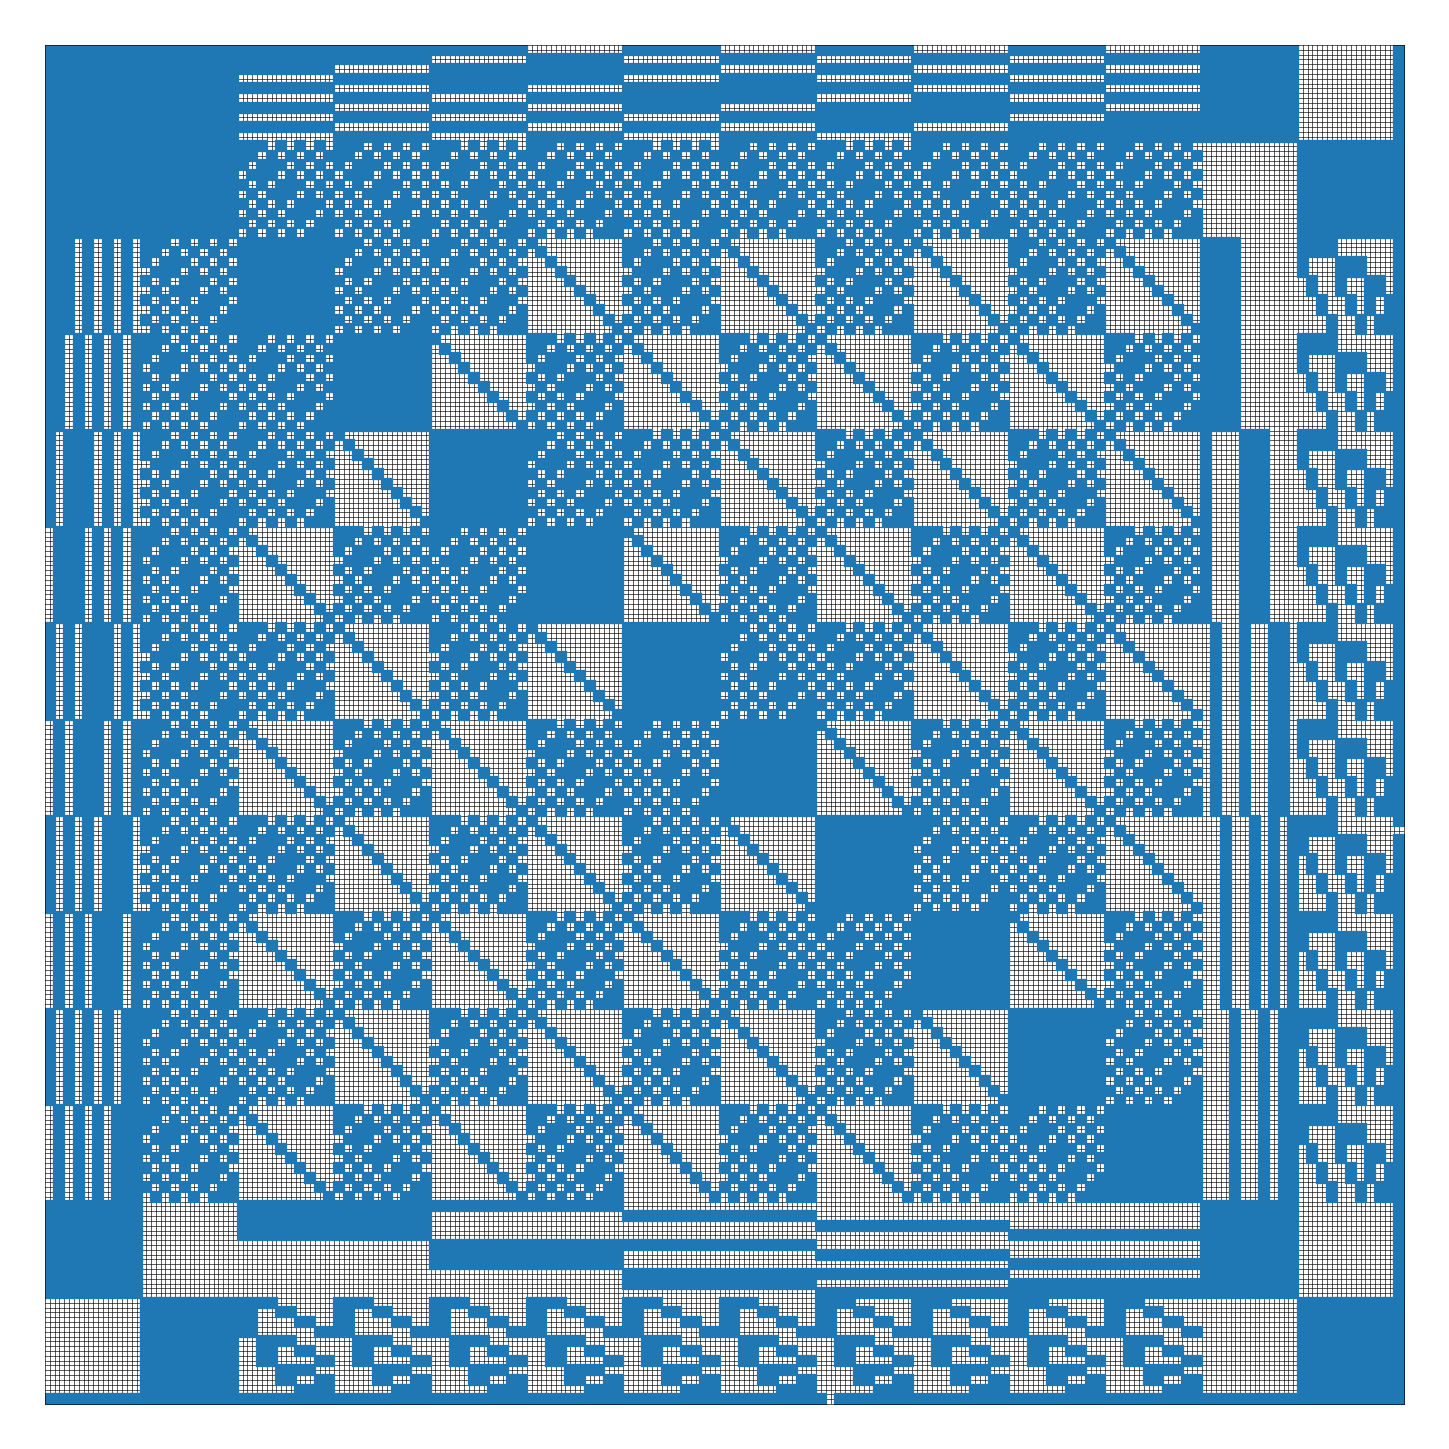

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
figure = plt.figure(dpi=450)
axes = figure.add_subplot(111)
# axes.xaxis.set_tick_params(which='major', size=0, width=0, direction='in', top='on')
# axes.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
plt.rcParams['axes.linewidth'] = 0.1
y=Hamiltonian_matrixCISD
axes.spy(y, markersize=1)
# caxes = axes.matshow(Hamiltonian_matrixFCI, interpolation ='nearest')
# figure.colorbar(caxes)
plt.grid()
plt.xticks(np.arange(0, len(y), 0.5))
plt.yticks(np.arange(0, len(y), 0.5))
# plt.axis('off')
plt.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,left=False, 
    # ticks along the top edge are off
    labelbottom=False,labeltop=False,labelleft=False,labelright=False,
    grid_color="black",grid_alpha=1,grid_linewidth=0.1
) # labels along the bottom edge are off

# axes.set_xticklabels(['']+alphabets)
# axes.set_yticklabels(['']+alphabets)
 
plt.show()

In [12]:
s= np.array([x[0] for x in sgreedy[:]])
# print(s)
E, C = np.linalg.eigh(A[np.ix_(sapsci, sapsci)])
Eg, C = np.linalg.eigh(A[np.ix_(s, s)])
# Eex, C = np.linalg.eigh(A[np.ix_(sgreedyex, sgreedyex)])
for i in range(0,10):
        print(i,"FCI :% 16.15f"% (e_fci[i]),"CISD   :% 16.15f"% (e_cisd[i]),"ap-sCI :% 16.15f"% (E[i]),"Greedy :% 16.15f"% (Eg[i]))
#     print(i,"CISD   :% 16.15f"% (e_cisd[i]),"ap-sCI :% 16.15f"% (E[i]),"Greedy :% 16.15f"% (Eg[i]))

0 FCI :-83.730648587054418 CISD   :-83.728855823066269 ap-sCI :-83.730648587054418 Greedy :-83.730648587054446
1 FCI :-83.457159196041829 CISD   :-83.426311291330066 ap-sCI :-83.366779618225621 Greedy :-83.366779618225635
2 FCI :-83.409932220195714 CISD   :-83.378450382307022 ap-sCI :-83.340474766494950 Greedy :-83.240599056191712
3 FCI :-83.374575012981808 CISD   :-83.339840345742715 ap-sCI :-83.271448587779588 Greedy :-83.221311352404783
4 FCI :-83.366779618225650 CISD   :-83.336968241016535 ap-sCI :-83.240599056191755 Greedy :-83.152707295314059
5 FCI :-83.340405009990363 CISD   :-83.306470799506116 ap-sCI :-83.195637185622701 Greedy :-83.144437235904149
6 FCI :-83.307981908309642 CISD   :-83.277003105910410 ap-sCI :-83.152707295314087 Greedy :-83.039355854707182
7 FCI :-83.240599056191726 CISD   :-83.221305551089770 ap-sCI :-83.050106490959649 Greedy :-82.985663178250249
8 FCI :-83.193928679946225 CISD   :-83.180092869150755 ap-sCI :-82.985663178250206 Greedy :-82.934059565910090
9

In [27]:
E_rl, sg = RL(A, k, mode='rl', max_pick=None)
E_rle, sge = RL(A, k, mode='rle', max_pick=None)
# print("RL2:    ", E_rl)

# E_rle, se1 = RL(A, k, mode='rle', max_pick=None,ex=1)
# E_rle, se2 = RL(A, k, mode='rle', max_pick=None,ex=2)
# E_rle, se3 = RL(A, k, mode='rle', max_pick=None,ex=3)
# E_rle, se4 = RL(A, k, mode='rle', max_pick=None,ex=4)
# E_rle, se5 = RL(A, k, mode='rle', max_pick=None,ex=5)

Best energy: -83.240599:   0%|                                                                                                                                                          | 0/30 [00:00<?, ?it/s]

[[-9.75759530e-01  2.06591860e-14  1.83904829e-14 ... -1.73630075e-16
   1.32580710e-16  9.70360944e-17]
 [-2.13995488e-14 -6.83566615e-01 -6.73545404e-01 ...  7.14782328e-17
  -4.51272203e-17 -9.31722300e-17]
 [ 5.10702591e-15  8.44059292e-15  5.86215906e-14 ...  1.37162589e-16
  -8.10747862e-17  1.11239543e-16]
 ...
 [-2.10828044e-17  1.03789996e-15 -1.20151793e-15 ... -4.24152353e-06
   1.07690148e-06 -1.41620750e-05]
 [-6.09741142e-03  3.46944695e-15 -2.41473508e-15 ... -1.34436253e-16
   1.72617754e-16  4.44414943e-16]
 [ 1.40340972e-16 -1.38777878e-17 -1.04083409e-16 ...  1.31207295e-01
   9.90959016e-01 -2.78962683e-02]]
vec  [-9.75759530e-01  2.06591860e-14  1.83904829e-14 -6.05930783e-15
  8.20840002e-15 -9.16333874e-15 -4.75427001e-02 -1.23408410e-14
  5.73350771e-15  8.64916187e-16 -2.66751312e-15  4.22509504e-03
 -5.75132264e-15  7.22617618e-15 -1.07263875e-15 -1.57458377e-15
  8.76967515e-15  4.86908420e-16 -5.59815275e-02  1.40200511e-02
  1.26995602e-15  3.39327011e-15  

Best energy: -83.402534:   3%|████▊                                                                                                                                             | 1/30 [00:01<00:42,  1.48s/it]

[[ 9.79669024e-01 -1.00466688e-14  9.25047239e-15 ...  4.41468182e-04
  -2.82425028e-06 -9.14795583e-20]
 [ 9.88098492e-15  6.84922075e-01 -6.76270904e-01 ...  1.45716772e-16
   6.45100293e-18 -3.84369661e-17]
 [ 3.21270788e-15 -6.25356728e-14 -2.05868584e-13 ... -4.44089210e-16
   6.76542156e-17  7.40913409e-18]
 ...
 [-3.94950973e-04 -1.52655666e-16  1.94289029e-16 ...  9.99995756e-01
  -4.96041047e-05 -2.13630705e-17]
 [-6.21299987e-17  2.01444764e-16  2.67147415e-16 ... -3.77912625e-16
  -4.27800688e-16  1.72596995e-06]
 [ 1.25356225e-18 -4.51028104e-17 -1.20129601e-16 ... -2.83877986e-17
  -4.69655506e-19  2.91445423e-17]]
vec  [ 9.79669024e-01 -1.00466688e-14  9.25047239e-15 -1.07127379e-05
  5.04465321e-15 -1.00868907e-14  4.57784544e-15  4.60963367e-02
 -1.16597937e-14  4.93711833e-16 -3.77672955e-06  2.49876057e-15
  1.19799591e-15  7.32870747e-16 -7.46432386e-07 -1.26800378e-16
 -4.89677476e-18 -6.94491425e-15  5.31301537e-02  1.05714489e-14
  3.05025852e-15 -1.23252257e-02 -

Best energy: -83.407466:   7%|█████████▋                                                                                                                                        | 2/30 [00:02<00:41,  1.49s/it]

[[ 9.79445697e-01 -1.02636533e-14  8.99344128e-15 ...  3.31322362e-06
  -3.01900475e-07 -5.98807356e-20]
 [-1.02418074e-14 -6.86435618e-01  6.78071398e-01 ... -7.48099499e-18
   1.90819582e-17 -1.07274540e-17]
 [-2.98372438e-16  4.99202405e-14 -1.31674382e-13 ...  1.38777878e-17
  -1.08420217e-18  4.45985357e-17]
 ...
 [ 8.25264185e-06 -1.38777878e-16  2.08166817e-16 ...  1.43979365e-05
  -4.65868898e-05  2.61956279e-16]
 [ 1.15514334e-21  1.90748501e-16 -5.42517295e-17 ...  4.50969049e-21
  -1.53676393e-20 -6.54629902e-22]
 [ 2.51967900e-19  2.08166817e-17 -6.93889390e-18 ... -5.91734811e-16
  -5.73956074e-16 -9.97567425e-01]]
vec  [ 9.79445697e-01 -1.02636533e-14  8.99344128e-15  2.82490108e-05
 -1.43936743e-15 -6.34198973e-15 -4.44883503e-02  2.42169988e-15
  4.64373430e-15  5.42602686e-04 -5.88242897e-16 -6.53149961e-15
 -1.10577709e-14 -2.10783428e-02  2.33351575e-15  3.82866178e-15
  3.42370637e-05 -4.94238318e-02  2.46978084e-16  1.15170613e-14
  7.69424348e-16  9.94287157e-04 -

Best energy: -83.409932:  10%|██████████████▌                                                                                                                                   | 3/30 [00:04<00:38,  1.42s/it]

[[ 9.81683477e-01 -5.51786648e-15  8.07257079e-05 ...  7.29075285e-07
  -8.89826573e-07 -2.56266510e-22]
 [-2.88619145e-02  1.29657453e-13 -6.64856661e-01 ... -1.37902768e-04
   4.29866703e-04 -2.59848162e-16]
 [ 1.08940634e-15 -1.32647209e-14  1.22479067e-13 ...  5.03069808e-17
  -4.16333634e-17  3.82799912e-18]
 ...
 [-1.01296194e-04  0.00000000e+00 -3.41428955e-05 ... -5.35817732e-04
  -1.72478988e-04  1.59167496e-16]
 [-1.47767546e-05 -2.22044605e-16  1.20273541e-04 ... -9.52346346e-01
  -3.04956211e-01 -8.81615185e-17]
 [-6.32969595e-06  1.94289029e-16  4.37813143e-05 ... -3.13301886e-06
  -1.59701026e-06 -6.27875242e-16]]
vec  [ 9.81683477e-01 -5.51786648e-15  8.07257079e-05 -2.40043152e-15
  6.18917166e-02 -1.88355538e-15  7.23264551e-04  6.61271441e-16
  1.33894157e-15  4.04718994e-15  1.27808442e-15 -6.05782832e-02
 -5.12100876e-14  3.24116450e-02  7.26693071e-14 -5.67742121e-02
 -7.45237564e-15 -1.25364352e-14 -1.83543590e-14 -1.88703653e-15
  2.05751830e-03  4.85882647e-15  

Best energy: -83.409932:  13%|███████████████████▍                                                                                                                              | 4/30 [00:05<00:37,  1.43s/it]

[[ 9.77594293e-01  1.06271001e-14 -8.78060286e-15 ... -1.07830922e-08
  -2.97850167e-19  1.49265208e-08]
 [ 9.88098492e-15 -6.59458612e-01  6.59911128e-01 ... -1.64904609e-17
  -3.46918353e-05 -2.04355169e-17]
 [-1.73472348e-18  4.36732652e-15 -3.20089547e-13 ... -7.28583860e-17
   2.05545193e-17 -4.16333634e-17]
 ...
 [ 9.64878639e-20 -3.32546853e-06  8.44964419e-06 ...  6.17483359e-20
  -1.08887448e-03 -3.80219340e-19]
 [-2.91850924e-17  8.76659947e-06  1.41416605e-05 ...  9.51554491e-16
  -6.42049411e-02  6.82055770e-16]
 [-1.62789975e-08  1.73472348e-17 -2.08166817e-17 ... -8.44213834e-01
  -3.35592760e-16 -5.35725247e-01]]
vec  [ 9.77594293e-01  1.06271001e-14 -8.78060286e-15 -1.67102045e-15
 -5.34133635e-16  2.24083083e-15 -1.16429973e-15 -2.36351750e-17
 -1.32148801e-15  6.19303408e-03 -5.54004908e-17 -1.68652341e-16
 -2.62389575e-16 -1.53593574e-15 -9.93695303e-16 -9.99848466e-15
 -2.62172972e-17 -1.97142339e-03 -2.10329525e-01  7.58805259e-15
  3.68618376e-16  5.35245359e-03 -

Best energy: -83.409932:  17%|████████████████████████▎                                                                                                                         | 5/30 [00:07<00:34,  1.40s/it]

[[-9.86647662e-01 -5.91936032e-15  1.69990043e-02 ... -4.05375198e-05
   2.18955326e-06 -1.25360876e-19]
 [-4.21884749e-15  9.68040381e-01  3.85802501e-15 ... -3.46944695e-18
  -3.14418630e-18  1.47299975e-05]
 [ 1.22471477e-15 -9.17482622e-14 -5.21827373e-13 ... -2.77555756e-17
   2.60208521e-18  1.15774155e-18]
 ...
 [-2.70876447e-21  4.55886772e-07 -2.82667838e-16 ...  4.25364971e-19
  -2.20068163e-17 -1.42770293e-03]
 [-1.07363323e-19 -3.25641817e-18  1.89274806e-17 ...  1.69189989e-18
  -5.05563387e-18 -2.56746274e-18]
 [ 1.72107275e-06 -7.80625564e-18 -8.82367148e-06 ...  3.96196183e-01
  -9.13238076e-01  1.30520594e-14]]
vec  [-9.86647662e-01 -5.91936032e-15  1.69990043e-02 -2.29736013e-14
 -2.53488746e-15  2.04865807e-14 -4.38583272e-02  3.77243795e-15
  4.50598002e-03  3.49329355e-16  6.77477631e-15  4.12442607e-16
 -6.20956131e-02 -4.77800819e-14 -8.83597602e-15 -1.36354768e-14
 -7.60429258e-15  1.54871015e-02  6.75955573e-16  1.36103896e-14
 -6.40188800e-02 -1.67079734e-16 -

Best energy: -83.409932:  20%|█████████████████████████████▏                                                                                                                    | 6/30 [00:08<00:32,  1.37s/it]

[[-9.82187429e-01  3.71710212e-15 -3.37781897e-15 ...  3.94651510e-18
  -2.92368959e-19  1.32272665e-17]
 [ 4.02455846e-15  6.80229425e-01 -6.71296200e-01 ...  1.44136906e-04
  -4.41159965e-05 -5.21186247e-05]
 [ 2.48691939e-02 -4.57212302e-15  3.39141564e-14 ...  1.51007548e-16
   9.78936425e-18 -5.13716890e-17]
 ...
 [ 3.01388587e-19  4.35297002e-05 -5.84876579e-05 ... -2.37256339e-03
   1.20852638e-02  1.38097618e-02]
 [-2.17100708e-19  8.32667268e-17 -1.11022302e-16 ...  1.00618383e-14
   2.45992329e-16  4.66978867e-15]
 [ 1.20135727e-19  1.36490737e-05 -2.98255176e-05 ...  1.20678484e-01
  -6.69866839e-01 -6.67893606e-01]]
vec  [-9.82187429e-01  3.71710212e-15 -3.37781897e-15  7.43524265e-06
 -5.36300042e-02  2.57994390e-14 -5.01250727e-16  1.94833924e-04
  1.29470041e-15  9.42132685e-16  2.10218544e-15  4.89504479e-15
  2.42872968e-16 -2.12467053e-03  6.22141083e-02 -7.45652475e-15
 -1.93342347e-16 -1.61430274e-04  1.27469578e-15  9.45490082e-16
  4.75905376e-15  6.09582572e-16  

Best energy: -83.409932:  23%|██████████████████████████████████                                                                                                                | 7/30 [00:09<00:30,  1.32s/it]

[[ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 ... -6.55780878e-18
  -1.06231606e-19  6.17995238e-18]
 [-3.96904731e-15 -6.80229407e-01  6.71296215e-01 ...  1.44106752e-04
   4.39255419e-05 -5.21803959e-05]
 [-2.48691939e-02  9.24620417e-15 -3.99831343e-14 ... -2.72519116e-17
   4.64789650e-17  2.36613578e-17]
 ...
 [-1.23577641e-19 -5.24235820e-06  3.35844944e-05 ... -6.30124780e-04
  -3.77814617e-03  4.32823424e-03]
 [-2.99819518e-19 -4.35579261e-05  5.81916903e-05 ... -2.37958176e-03
  -1.21226269e-02  1.39188076e-02]
 [-1.21014530e-19 -1.36379050e-05  2.99424998e-05 ...  1.20424827e-01
   6.68117698e-01 -6.69733178e-01]]
vec  [ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 -7.43524265e-06
  5.36300042e-02 -2.86993831e-14  8.39645893e-16  1.94833924e-04
 -5.61708148e-16  1.77943777e-15  2.13708384e-15  4.32115038e-15
  5.27954799e-16 -2.12467053e-03  6.22141083e-02  1.99016458e-14
  9.10519417e-16 -1.61430274e-04 -3.42648974e-15 -7.94441237e-15
 -5.79922721e-15 -6.46099616e-15  

Best energy: -83.409932:  27%|██████████████████████████████████████▉                                                                                                           | 8/30 [00:10<00:28,  1.29s/it]

[[ 9.82442034e-01 -2.11591629e-14  2.22744366e-14 ...  1.04123516e-09
   4.38502660e-22 -5.21963287e-09]
 [-2.26763053e-14 -6.21737806e-01  7.26475662e-01 ...  4.01432737e-18
  -7.20929775e-06  6.30086634e-18]
 [-2.54360044e-02  1.12404314e-14  3.98748739e-14 ...  1.17135963e-09
  -3.77129213e-17 -5.29165568e-09]
 ...
 [ 4.79299816e-05 -2.77555756e-16  1.11022302e-16 ... -1.26363094e-04
  -4.36137265e-18  6.78830962e-04]
 [-1.07346410e-18 -2.33402590e-05  5.12281879e-05 ...  4.77065576e-17
   1.39894165e-03 -5.86366936e-17]
 [-1.53503751e-07 -3.46944695e-18  0.00000000e+00 ...  3.22771856e-01
   2.12710302e-16 -9.39054246e-01]]
vec  [ 9.82442034e-01 -2.11591629e-14  2.22744366e-14 -4.15579404e-03
  2.50678984e-16  6.18973858e-02  8.89447593e-15  2.16495470e-16
  2.41048521e-03 -7.46424671e-17 -8.31649026e-16  1.32077444e-15
  4.49326466e-15  1.05673876e-15  3.54976676e-15  9.58899487e-16
 -1.01857909e-02 -2.00781666e-14  7.28697136e-02  7.89442309e-15
  2.69912323e-14 -7.44415459e-03 -

Best energy: -83.409932:  30%|███████████████████████████████████████████▊                                                                                                      | 9/30 [00:12<00:27,  1.29s/it]

[[-9.93549601e-01 -3.84874738e-16  1.63403973e-15 ...  9.05237979e-06
  -1.06048240e-20 -1.18829112e-05]
 [ 1.06858966e-15 -5.96426521e-01  7.57217010e-01 ...  1.17093835e-17
  -2.15195092e-09 -1.82145965e-17]
 [-1.07205911e-15  2.20651498e-14 -3.71591597e-14 ... -1.73472348e-18
  -5.73826769e-18  3.46944695e-18]
 ...
 [-1.40970156e-06 -5.20417043e-18 -1.04083409e-16 ...  2.57114686e-03
  -1.44072727e-16 -7.75422368e-03]
 [-1.50117829e-07  8.32667268e-17  1.52655666e-16 ...  6.07648077e-04
  -3.92033164e-17 -5.50590416e-03]
 [-3.60625308e-07 -1.73472348e-18 -1.56125113e-17 ...  2.43427986e-01
   1.26603405e-16 -9.69548632e-01]]
vec  [-9.93549601e-01 -3.84874738e-16  1.63403973e-15  1.07900428e-16
  1.32731473e-04  8.73751823e-15  2.20681838e-02 -3.79157088e-15
  1.89918013e-04 -3.28824562e-16 -6.28527179e-16 -1.98026366e-17
  2.54540587e-15  7.78218895e-16 -3.38752624e-02 -3.47397611e-15
 -1.37756082e-14  8.99893642e-16  6.89851215e-16  6.09958187e-16
  1.06393999e-15  6.28362432e-03 -

Best energy: -83.409932:  33%|████████████████████████████████████████████████▎                                                                                                | 10/30 [00:13<00:26,  1.33s/it]

[[ 9.90542846e-01 -3.79839088e-15  4.46079719e-15 ...  9.07193581e-06
   1.06193238e-20 -1.18925630e-05]
 [ 3.96904731e-15  5.62134904e-01 -7.87210205e-01 ... -1.90819582e-17
   1.42506904e-09  2.60208521e-18]
 [ 8.70831185e-16  8.15054012e-15  5.28674838e-14 ...  5.20417043e-18
   4.47895701e-18 -1.04083409e-17]
 ...
 [-1.17638509e-05 -1.38777878e-16  2.77555756e-17 ... -6.13162816e-05
  -1.63682911e-16  2.46620212e-04]
 [ 4.40186860e-08 -1.94289029e-16  9.71445147e-17 ...  6.41516560e-04
   7.70155941e-17 -5.59589774e-03]
 [ 3.88865911e-07  5.20417043e-18  1.04083409e-17 ...  2.43688287e-01
  -1.22564366e-16 -9.69516587e-01]]
vec  [ 9.90542846e-01 -3.79839088e-15  4.46079719e-15 -1.57906781e-16
  5.05521209e-03  2.09877407e-15  3.42398353e-02  6.22632789e-15
  1.42847297e-02  1.63288456e-15 -2.02368285e-15 -1.52562718e-16
 -2.95589570e-15  1.31463585e-16 -4.69943088e-15  4.53069550e-02
 -7.51155339e-16 -2.15078393e-14 -9.23948812e-16  2.82648002e-02
  4.09171809e-15  2.36813708e-15  

Best energy: -83.409932:  37%|█████████████████████████████████████████████████████▏                                                                                           | 11/30 [00:15<00:30,  1.60s/it]

[[ 9.92765960e-01  2.22293744e-15 -7.99474475e-16 ...  1.25741076e-20
  -1.21657021e-20 -1.18936361e-05]
 [-1.62370117e-15  5.62128926e-01 -7.87215250e-01 ... -4.24540442e-07
  -2.03795736e-07 -3.46944695e-18]
 [ 4.30211422e-16  2.06617298e-14  1.73803142e-13 ... -5.17812996e-18
  -1.86832045e-18  0.00000000e+00]
 ...
 [-1.34710696e-08 -4.16333634e-17 -5.55111512e-17 ...  4.16333634e-17
  -7.89299182e-17 -5.59590903e-03]
 [ 1.18571171e-20 -2.63023389e-06 -2.49371353e-05 ... -8.50290746e-01
  -5.26097034e-01 -8.14151492e-16]
 [ 3.28513718e-07 -3.46944695e-18  1.04083409e-17 ...  4.92010946e-16
   6.51334455e-16 -9.69516067e-01]]
vec  [ 9.92765960e-01  2.22293744e-15 -7.99474475e-16 -4.41867043e-16
  6.81639462e-03 -1.77913388e-16 -1.29856626e-15  1.51303284e-02
  1.14895744e-14 -1.23582787e-03 -1.60602689e-15  3.06916440e-16
  6.14557425e-16 -8.85703236e-16 -1.27594064e-16  1.47271270e-16
  9.00164055e-16  4.10749113e-16  3.31928188e-02 -3.08933999e-17
 -2.46038968e-16 -9.50729513e-16 -

Best energy: -83.409932:  40%|██████████████████████████████████████████████████████████                                                                                       | 12/30 [00:17<00:30,  1.69s/it]

[[ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 ... -6.55780878e-18
  -1.06231606e-19  6.17995238e-18]
 [-3.96904731e-15 -6.80229407e-01  6.71296215e-01 ...  1.44106752e-04
   4.39255419e-05 -5.21803959e-05]
 [-2.48691939e-02  9.24620417e-15 -3.99831343e-14 ... -2.72519116e-17
   4.64789650e-17  2.36613578e-17]
 ...
 [-1.23577641e-19 -5.24235820e-06  3.35844944e-05 ... -6.30124780e-04
  -3.77814617e-03  4.32823424e-03]
 [-2.99819518e-19 -4.35579261e-05  5.81916903e-05 ... -2.37958176e-03
  -1.21226269e-02  1.39188076e-02]
 [-1.21014530e-19 -1.36379050e-05  2.99424998e-05 ...  1.20424827e-01
   6.68117698e-01 -6.69733178e-01]]
vec  [ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 -7.43524265e-06
  5.36300042e-02 -2.86993831e-14  8.39645893e-16  1.94833924e-04
 -5.61708148e-16  1.77943777e-15  2.13708384e-15  4.32115038e-15
  5.27954799e-16 -2.12467053e-03  6.22141083e-02  1.99016458e-14
  9.10519417e-16 -1.61430274e-04 -3.42648974e-15 -7.94441237e-15
 -5.79922721e-15 -6.46099616e-15  

Best energy: -83.409932:  43%|██████████████████████████████████████████████████████████████▊                                                                                  | 13/30 [00:20<00:34,  2.05s/it]

[[ 9.87087557e-01 -1.02963844e-14  1.34004384e-14 ... -3.91011093e-20
  -5.67512075e-20  1.18879885e-05]
 [-1.18238752e-14 -5.54761449e-01  7.92840353e-01 ... -3.30683760e-07
  -3.26881282e-07  6.93889390e-18]
 [-2.18575158e-16  7.25302482e-15 -1.40813031e-15 ...  2.80493314e-18
  -2.17717195e-17  0.00000000e+00]
 ...
 [ 1.51164960e-06 -2.08166817e-17 -5.55111512e-17 ... -4.16333634e-17
   2.35922393e-16  5.50613660e-03]
 [-1.79805801e-19  3.00013073e-06  2.31222478e-05 ... -7.08151166e-01
  -7.06059008e-01  8.10874862e-16]
 [ 1.07231962e-06  3.46944695e-18 -8.67361738e-18 ...  3.83157048e-16
   7.81059245e-16  9.69548170e-01]]
vec  [ 9.87087557e-01 -1.02963844e-14  1.34004384e-14 -1.68489413e-02
 -2.41892568e-16  6.74286141e-15  4.63528928e-02  1.65300901e-14
 -1.00011800e-02  8.71760331e-16  2.11699196e-15  5.81747637e-17
  2.21503880e-15  7.05495018e-15  2.14207521e-15  5.48627922e-02
  3.62425491e-15  1.61162625e-15 -1.60343123e-02 -1.31545196e-15
 -5.30357643e-16 -3.36321859e-15 -

Best energy: -83.409932:  47%|███████████████████████████████████████████████████████████████████▋                                                                             | 14/30 [00:23<00:37,  2.32s/it]

[[ 9.87654601e-01 -4.46743822e-16  1.28288670e-16 ...  4.45195464e-19
  -1.85537731e-20  1.18897780e-05]
 [-8.32667268e-17 -5.62128881e-01  7.87215253e-01 ... -1.34143352e-07
   4.90189321e-08  6.07153217e-18]
 [ 5.30825384e-16  1.48055409e-14 -9.52196893e-14 ... -4.91376074e-17
   9.65532892e-18 -6.93889390e-18]
 ...
 [-6.47525183e-20  5.15422562e-06  4.67744409e-05 ...  5.44915049e-04
   1.36541216e-03  6.05313775e-17]
 [ 1.17238307e-07 -4.16333634e-17  2.08166817e-17 ...  3.64291930e-17
  -4.94565597e-17  5.50711186e-03]
 [ 6.43756440e-07 -3.12250226e-17 -1.04083409e-17 ... -1.63221216e-15
   8.56051731e-17  9.69548160e-01]]
vec  [ 9.87654601e-01 -4.46743822e-16  1.28288670e-16 -2.63303983e-02
  5.99373507e-16  1.50950254e-14  4.64200897e-02  3.95254933e-14
 -2.04065125e-02  3.01027297e-15 -9.18602156e-16 -6.73340317e-16
 -7.21244843e-16 -4.97603018e-16  2.26438092e-14  4.81638914e-02
 -4.83877067e-03  4.31668509e-15  4.77844910e-15  1.11943255e-15
  8.26936860e-16  2.85040077e-16  

Best energy: -83.409932:  50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 15/30 [00:27<00:41,  2.78s/it]

[[-9.86653360e-01 -2.73245614e-15 -2.64467415e-17 ...  3.78696348e-20
   9.06559321e-06 -1.18907895e-05]
 [ 9.15933995e-16 -5.54753203e-01  7.92844683e-01 ...  5.13765600e-17
   4.33680869e-18  6.07153217e-18]
 [-8.15320034e-16  3.18031862e-14 -2.57239826e-14 ... -8.72221999e-10
  -2.08166817e-17  3.46944695e-18]
 ...
 [-4.28927499e-07 -1.38777878e-16 -1.66533454e-16 ... -1.06236037e-16
   2.57153367e-03 -7.75468174e-03]
 [-4.17391937e-06 -1.38777878e-17 -5.55111512e-17 ... -2.08431038e-16
   6.07299388e-04 -5.50471039e-03]
 [ 1.34963471e-07  4.16333634e-17  2.77555756e-17 ... -1.17257815e-17
   2.43426954e-01 -9.69548221e-01]]
vec  [-9.86653360e-01 -2.73245614e-15 -2.64467415e-17  1.34294714e-02
 -1.00528179e-15 -5.52583370e-15 -5.02046465e-02 -2.44415257e-14
  1.37949899e-02  4.75126895e-15 -5.15709292e-16  6.66279896e-15
 -1.15941051e-14  4.86514784e-02 -1.44202106e-14 -3.73578710e-15
 -3.64558639e-15  2.53583923e-02  2.48341719e-15 -1.30657632e-02
 -8.02405907e-15 -2.10886727e-16 -

Best energy: -83.409932:  53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 16/30 [00:30<00:41,  2.97s/it]

[[ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 ... -6.55780878e-18
  -1.06231606e-19  6.17995238e-18]
 [-3.96904731e-15 -6.80229407e-01  6.71296215e-01 ...  1.44106752e-04
   4.39255419e-05 -5.21803959e-05]
 [-2.48691939e-02  9.24620417e-15 -3.99831343e-14 ... -2.72519116e-17
   4.64789650e-17  2.36613578e-17]
 ...
 [-1.23577641e-19 -5.24235820e-06  3.35844944e-05 ... -6.30124780e-04
  -3.77814617e-03  4.32823424e-03]
 [-2.99819518e-19 -4.35579261e-05  5.81916903e-05 ... -2.37958176e-03
  -1.21226269e-02  1.39188076e-02]
 [-1.21014530e-19 -1.36379050e-05  2.99424998e-05 ...  1.20424827e-01
   6.68117698e-01 -6.69733178e-01]]
vec  [ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 -7.43524265e-06
  5.36300042e-02 -2.86993831e-14  8.39645893e-16  1.94833924e-04
 -5.61708148e-16  1.77943777e-15  2.13708384e-15  4.32115038e-15
  5.27954799e-16 -2.12467053e-03  6.22141083e-02  1.99016458e-14
  9.10519417e-16 -1.61430274e-04 -3.42648974e-15 -7.94441237e-15
 -5.79922721e-15 -6.46099616e-15  

Best energy: -83.409932:  57%|██████████████████████████████████████████████████████████████████████████████████▏                                                              | 17/30 [00:34<00:40,  3.13s/it]

[[ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 ... -6.55780878e-18
  -1.06231606e-19  6.17995238e-18]
 [-3.96904731e-15 -6.80229407e-01  6.71296215e-01 ...  1.44106752e-04
   4.39255419e-05 -5.21803959e-05]
 [-2.48691939e-02  9.24620417e-15 -3.99831343e-14 ... -2.72519116e-17
   4.64789650e-17  2.36613578e-17]
 ...
 [-1.23577641e-19 -5.24235820e-06  3.35844944e-05 ... -6.30124780e-04
  -3.77814617e-03  4.32823424e-03]
 [-2.99819518e-19 -4.35579261e-05  5.81916903e-05 ... -2.37958176e-03
  -1.21226269e-02  1.39188076e-02]
 [-1.21014530e-19 -1.36379050e-05  2.99424998e-05 ...  1.20424827e-01
   6.68117698e-01 -6.69733178e-01]]
vec  [ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 -7.43524265e-06
  5.36300042e-02 -2.86993831e-14  8.39645893e-16  1.94833924e-04
 -5.61708148e-16  1.77943777e-15  2.13708384e-15  4.32115038e-15
  5.27954799e-16 -2.12467053e-03  6.22141083e-02  1.99016458e-14
  9.10519417e-16 -1.61430274e-04 -3.42648974e-15 -7.94441237e-15
 -5.79922721e-15 -6.46099616e-15  

Best energy: -83.409932:  60%|███████████████████████████████████████████████████████████████████████████████████████                                                          | 18/30 [00:36<00:35,  2.96s/it]

[[ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 ... -6.55780878e-18
  -1.06231606e-19  6.17995238e-18]
 [-3.96904731e-15 -6.80229407e-01  6.71296215e-01 ...  1.44106752e-04
   4.39255419e-05 -5.21803959e-05]
 [-2.48691939e-02  9.24620417e-15 -3.99831343e-14 ... -2.72519116e-17
   4.64789650e-17  2.36613578e-17]
 ...
 [-1.23577641e-19 -5.24235820e-06  3.35844944e-05 ... -6.30124780e-04
  -3.77814617e-03  4.32823424e-03]
 [-2.99819518e-19 -4.35579261e-05  5.81916903e-05 ... -2.37958176e-03
  -1.21226269e-02  1.39188076e-02]
 [-1.21014530e-19 -1.36379050e-05  2.99424998e-05 ...  1.20424827e-01
   6.68117698e-01 -6.69733178e-01]]
vec  [ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 -7.43524265e-06
  5.36300042e-02 -2.86993831e-14  8.39645893e-16  1.94833924e-04
 -5.61708148e-16  1.77943777e-15  2.13708384e-15  4.32115038e-15
  5.27954799e-16 -2.12467053e-03  6.22141083e-02  1.99016458e-14
  9.10519417e-16 -1.61430274e-04 -3.42648974e-15 -7.94441237e-15
 -5.79922721e-15 -6.46099616e-15  

Best energy: -83.409932:  63%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 19/30 [00:40<00:36,  3.29s/it]

[[ 9.82073956e-01 -5.53211103e-15  6.07349392e-15 ... -8.57840521e-06
  -1.06774893e-20  1.20137897e-05]
 [-7.10542736e-15 -5.62123513e-01  7.87217756e-01 ...  1.08420217e-17
  -7.20898256e-10  1.30104261e-17]
 [-8.18789481e-16 -9.75294647e-15 -7.03019144e-14 ... -5.20417043e-18
  -4.98720803e-18  1.38777878e-17]
 ...
 [ 6.54895114e-06  8.32667268e-17 -1.11022302e-16 ... -6.08128325e-04
  -3.68357688e-17  5.50575217e-03]
 [ 3.91365371e-19 -1.77199293e-17  5.24902929e-16 ...  1.41196202e-17
   3.27996143e-18 -2.69410048e-17]
 [-1.52802893e-06  6.93889390e-18 -2.08166817e-17 ... -2.43535026e-01
   9.96271682e-17  9.69521306e-01]]
vec  [ 9.82073956e-01 -5.53211103e-15  6.07349392e-15 -2.52382267e-03
 -1.64266508e-15 -1.37007409e-16  5.53144634e-02  1.50247702e-14
 -1.98924159e-03 -6.03753169e-15 -6.69517349e-17 -6.48540840e-16
  7.99081302e-16  2.93110241e-03 -3.24767560e-15 -5.99435010e-02
  1.54606353e-15  7.11506385e-03 -7.69851295e-15 -4.45897442e-15
 -5.59737713e-03  1.37031592e-15  

Best energy: -83.409932:  67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 20/30 [00:47<00:43,  4.36s/it]

[[-9.82074875e-01  2.99555837e-15 -4.58905764e-15 ... -8.57973869e-06
   1.03714617e-20  1.20139961e-05]
 [ 4.38538095e-15  5.45725361e-01 -7.95985109e-01 ...  9.32413868e-18
   6.96544190e-10  1.17093835e-17]
 [ 1.24900090e-16  2.47455819e-15  1.78439584e-14 ...  5.20417043e-18
  -7.10024558e-18 -3.46944695e-18]
 ...
 [-6.42443443e-06 -2.42861287e-16 -1.63064007e-16 ... -6.07513796e-04
   2.50199980e-16  5.50587475e-03]
 [-3.10411785e-19 -1.13504109e-16 -3.40541126e-17 ...  1.41311708e-17
  -3.66750377e-19 -2.69563250e-17]
 [ 1.33477393e-06 -1.38777878e-17  1.38777878e-17 ... -2.43431919e-01
  -1.25631927e-16  9.69547297e-01]]
vec  [-9.82074875e-01  2.99555837e-15 -4.58905764e-15  2.60051922e-03
 -1.93270831e-16 -3.08544587e-15 -5.52853234e-02 -7.11482869e-16
 -2.04466505e-03  3.60684370e-15  1.80270316e-15  2.02618899e-15
  1.61940467e-15  3.05077068e-15  7.14105120e-15 -3.19018816e-03
  5.98829382e-02  1.11759567e-14  1.50993714e-15 -6.29865638e-03
 -5.12190678e-15  4.61142435e-03  

Best energy: -83.409932:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 21/30 [00:54<00:46,  5.22s/it]

[[ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 ... -6.55780878e-18
  -1.06231606e-19  6.17995238e-18]
 [-3.96904731e-15 -6.80229407e-01  6.71296215e-01 ...  1.44106752e-04
   4.39255419e-05 -5.21803959e-05]
 [-2.48691939e-02  9.24620417e-15 -3.99831343e-14 ... -2.72519116e-17
   4.64789650e-17  2.36613578e-17]
 ...
 [-1.23577641e-19 -5.24235820e-06  3.35844944e-05 ... -6.30124780e-04
  -3.77814617e-03  4.32823424e-03]
 [-2.99819518e-19 -4.35579261e-05  5.81916903e-05 ... -2.37958176e-03
  -1.21226269e-02  1.39188076e-02]
 [-1.21014530e-19 -1.36379050e-05  2.99424998e-05 ...  1.20424827e-01
   6.68117698e-01 -6.69733178e-01]]
vec  [ 9.82187429e-01 -3.78133988e-15  3.42982340e-15 -7.43524265e-06
  5.36300042e-02 -2.86993831e-14  8.39645893e-16  1.94833924e-04
 -5.61708148e-16  1.77943777e-15  2.13708384e-15  4.32115038e-15
  5.27954799e-16 -2.12467053e-03  6.22141083e-02  1.99016458e-14
  9.10519417e-16 -1.61430274e-04 -3.42648974e-15 -7.94441237e-15
 -5.79922721e-15 -6.46099616e-15  

Best energy: -83.409932:  73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 22/30 [01:08<01:01,  7.73s/it]

[[ 9.81299468e-01 -4.71403007e-15  5.47445315e-15 ...  6.16429504e-19
  -8.58028192e-06  1.20122574e-05]
 [-4.77395901e-15 -5.54753185e-01  7.92844695e-01 ... -6.42404556e-18
  -3.12250226e-17 -1.30104261e-17]
 [-3.22658567e-16 -4.90167705e-15 -2.81496210e-15 ...  5.95002253e-18
  -1.56125113e-17  3.46944695e-18]
 ...
 [ 5.43690900e-06  1.52655666e-16  3.12250226e-17 ...  1.57351617e-16
  -6.08065670e-04  5.50550440e-03]
 [ 3.95776191e-19  4.47233396e-18  9.85726122e-17 ...  3.81309037e-04
   1.41594750e-17 -2.69535412e-17]
 [-1.04526320e-06 -1.38777878e-17  1.04083409e-17 ...  9.60040695e-16
  -2.43535685e-01  9.69520851e-01]]
vec  [ 9.81299468e-01 -4.71403007e-15  5.47445315e-15 -3.00223947e-03
  3.77374085e-16  1.64829915e-14  5.87829694e-02 -5.26146456e-17
 -2.55039449e-03 -4.66078103e-16 -8.99880652e-16 -2.48347311e-15
  2.75500828e-03 -6.49572484e-02 -7.51112536e-15 -6.42671103e-15
 -7.93472795e-16  6.84617803e-03  4.53094299e-15  2.43879098e-14
 -7.20630979e-03 -1.75013200e-15 -

Best energy: -83.409932:  77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 23/30 [01:21<01:04,  9.17s/it]

[[ 9.81299941e-01  9.33831703e-15 -1.58619549e-14 ...  6.16421766e-19
  -8.58028181e-06  1.20122561e-05]
 [ 1.33781874e-14 -5.45725530e-01  7.95984993e-01 ...  2.51672512e-18
  -8.45677695e-18 -3.90312782e-18]
 [-1.39818712e-15  2.13706241e-14 -6.60213356e-15 ...  3.75572165e-18
   0.00000000e+00  1.04083409e-17]
 ...
 [ 5.17496793e-06 -2.77555756e-16 -4.71844785e-16 ... -6.84267096e-17
  -6.08065586e-04  5.50550339e-03]
 [ 4.15094746e-19 -2.21109481e-17  4.31207533e-17 ...  3.81309955e-04
   1.41617081e-17 -2.69547623e-17]
 [-1.04550566e-06 -6.93889390e-18  1.04083409e-17 ...  9.70615054e-16
  -2.43535685e-01  9.69520851e-01]]
vec  [ 9.81299941e-01  9.33831703e-15 -1.58619549e-14 -3.00401732e-03
 -2.78868977e-15 -9.84322356e-15  5.88830950e-02 -6.22094964e-15
  1.79733667e-03  4.48909504e-15  1.56737898e-15  6.51687715e-15
  1.84751926e-15  3.87347380e-15  8.02725907e-15 -2.65293439e-03
  6.50822455e-02  1.59642793e-15  1.10250376e-14 -7.48302823e-03
 -1.17810723e-15  8.05168042e-03  

Best energy: -83.409932:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 24/30 [01:35<01:04, 10.78s/it]

[[ 9.87666320e-01  7.78209941e-16 -2.32380290e-15 ... -7.23029863e-19
  -3.29689434e-20 -1.18696039e-05]
 [-1.58206781e-15  6.80229402e-01 -6.71296198e-01 ...  4.39012963e-05
   5.20534926e-05  2.60208521e-18]
 [-2.82522612e-02 -3.23068478e-14 -1.12916312e-14 ...  5.83643177e-17
  -1.73371446e-17  4.63715299e-07]
 ...
 [-1.04874681e-17  4.34987683e-05 -5.81757744e-05 ... -1.21535078e-02
  -1.38803908e-02 -4.23396824e-17]
 [-2.86666600e-17  1.36204411e-05 -2.99363797e-05 ...  6.69747422e-01
   6.67806156e-01 -9.68082153e-16]
 [ 7.21297770e-07 -2.77555756e-17  5.55111512e-17 ... -3.87819117e-16
  -9.36547389e-16 -9.69520664e-01]]
vec  [ 9.87666320e-01  7.78209941e-16 -2.32380290e-15  1.18111142e-02
 -2.00714541e-15 -4.81728346e-02 -9.96541014e-15  5.51464116e-15
 -8.77056844e-03 -8.06262658e-16 -2.43728545e-15  4.06706704e-16
 -1.92249895e-16 -1.91257533e-15 -5.00533508e-02  1.22685788e-15
  1.11987304e-14  1.50431396e-02 -3.65125069e-15 -1.91622707e-15
 -1.41122874e-15 -4.33768304e-13  

Best energy: -83.409932:  83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 25/30 [01:55<01:07, 13.47s/it]

[[ 9.81349548e-01 -6.99705406e-15  7.54421874e-15 ...  5.31099523e-19
   2.43945489e-19  1.20132329e-05]
 [-7.91033905e-15 -6.23964493e-01  7.38189660e-01 ... -4.15471217e-17
  -1.82085114e-09 -5.20417043e-18]
 [ 4.99600361e-16  3.23839306e-15 -1.87961265e-14 ... -2.15045109e-17
   1.77809159e-17 -3.46944695e-18]
 ...
 [ 5.18192966e-06 -3.88578059e-16 -2.77555756e-16 ... -6.17995238e-18
  -2.37223435e-16  5.50663159e-03]
 [ 3.70048588e-19 -4.60176060e-17  2.59158201e-17 ... -7.29106129e-04
  -6.97955149e-19 -2.52290858e-17]
 [-9.94441789e-07  6.93889390e-18 -1.04083409e-17 ...  4.48934238e-15
   1.11152407e-15  9.69521016e-01]]
vec  [ 9.81349548e-01 -6.99705406e-15  7.54421874e-15 -1.37231631e-03
  2.68404953e-15  1.76199143e-14  5.78695087e-02  1.49060517e-15
 -2.19198054e-03 -5.85413745e-15 -1.07011330e-16 -6.14945382e-15
  9.90567542e-03  1.38312642e-14 -6.61687651e-02 -1.29909794e-14
 -1.99591572e-15 -8.58897933e-15  9.45111532e-04  7.52374318e-15
 -3.18928797e-03 -6.48446588e-16 -

Best energy: -83.409932:  87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 26/30 [02:13<00:59, 14.80s/it]

[[ 9.81349428e-01  4.41178500e-15 -4.82561045e-15 ... -8.58024005e-06
  -9.84675801e-21  1.20142420e-05]
 [ 5.02375919e-15 -6.21683325e-01  7.31905406e-01 ... -6.46184495e-17
  -5.04438972e-07 -1.30104261e-17]
 [ 5.20417043e-16  7.83941339e-15 -1.26812763e-14 ...  1.73472348e-17
  -8.28416241e-19  3.46944695e-18]
 ...
 [ 5.64435329e-06 -2.22044605e-16 -5.55111512e-17 ... -6.08061223e-04
  -7.80625564e-17  5.50700137e-03]
 [ 4.24287637e-19 -1.31412080e-16 -5.62497640e-17 ...  1.42064644e-17
  -7.80679827e-19 -2.69549790e-17]
 [-1.06795178e-06  1.38777878e-17  3.46944695e-18 ... -2.43431966e-01
   1.21105383e-16  9.69547290e-01]]
vec  [ 9.81349428e-01  4.41178500e-15 -4.82561045e-15 -4.35479175e-03
  2.89080695e-15 -4.14175800e-16  5.82239387e-02 -4.13297303e-16
 -1.05492309e-03  1.09988760e-15  1.69261489e-15  1.95132196e-15
  3.40086158e-15  2.43062596e-15  4.61895509e-15 -3.73081228e-02
  5.49542860e-02  7.33587907e-16  1.84502474e-15  1.18335103e-14
 -2.47220088e-03 -5.46626162e-16 -

Best energy: -83.409932:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 27/30 [02:33<00:49, 16.41s/it]

[[ 9.82111564e-01  4.73805641e-15 -5.22320051e-15 ... -8.52760143e-06
  -9.31736242e-21  1.20275186e-05]
 [-5.68989300e-15  6.40494313e-01 -7.22747862e-01 ... -3.90312782e-18
  -1.82089953e-09 -1.73472348e-17]
 [-6.07153217e-16  2.17030147e-15 -3.99195242e-14 ...  5.20417043e-18
  -6.55264657e-18 -2.08166817e-17]
 ...
 [ 6.17153684e-06  3.88578059e-16  2.77555756e-16 ... -6.08089447e-04
   4.85722573e-17  5.50699501e-03]
 [ 3.59763118e-19  2.34966940e-17 -1.42301535e-17 ...  1.41920019e-17
   1.11046019e-18 -2.69551550e-17]
 [-1.31127173e-06  1.04083409e-17  2.77555756e-17 ... -2.43436881e-01
   1.33119698e-16  9.69545815e-01]]
vec  [ 9.82111564e-01  4.73805641e-15 -5.22320051e-15  1.39186160e-03
 -5.57549588e-15  1.29187773e-14  5.42508452e-02 -9.24188989e-15
  1.71006126e-03  7.46983013e-15  3.61841446e-16  3.05333077e-15
  3.18652456e-15 -1.10349208e-02  5.94866413e-02  2.21845532e-15
  4.54222560e-15  6.97671092e-15 -3.78585487e-03 -1.44953023e-15
  5.36623882e-03  6.70821654e-16  

Best energy: -83.409932:  93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 28/30 [02:55<00:36, 18.12s/it]

[[ 9.87666320e-01  7.78209941e-16 -2.32380290e-15 ... -7.23029863e-19
  -3.29689434e-20 -1.18696039e-05]
 [-1.58206781e-15  6.80229402e-01 -6.71296198e-01 ...  4.39012963e-05
   5.20534926e-05  2.60208521e-18]
 [-2.82522612e-02 -3.23068478e-14 -1.12916312e-14 ...  5.83643177e-17
  -1.73371446e-17  4.63715299e-07]
 ...
 [-1.04874681e-17  4.34987683e-05 -5.81757744e-05 ... -1.21535078e-02
  -1.38803908e-02 -4.23396824e-17]
 [-2.86666600e-17  1.36204411e-05 -2.99363797e-05 ...  6.69747422e-01
   6.67806156e-01 -9.68082153e-16]
 [ 7.21297770e-07 -2.77555756e-17  5.55111512e-17 ... -3.87819117e-16
  -9.36547389e-16 -9.69520664e-01]]
vec  [ 9.87666320e-01  7.78209941e-16 -2.32380290e-15  1.18111142e-02
 -2.00714541e-15 -4.81728346e-02 -9.96541014e-15  5.51464116e-15
 -8.77056844e-03 -8.06262658e-16 -2.43728545e-15  4.06706704e-16
 -1.92249895e-16 -1.91257533e-15 -5.00533508e-02  1.22685788e-15
  1.11987304e-14  1.50431396e-02 -3.65125069e-15 -1.91622707e-15
 -1.41122874e-15 -4.33768304e-13  

Best energy: -83.409932:  97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 29/30 [03:18<00:19, 19.55s/it]

[[ 9.82111564e-01  4.73805641e-15 -5.22320051e-15 ... -8.52760143e-06
  -9.31736242e-21  1.20275186e-05]
 [-5.68989300e-15  6.40494313e-01 -7.22747862e-01 ... -3.90312782e-18
  -1.82089953e-09 -1.73472348e-17]
 [-6.07153217e-16  2.17030147e-15 -3.99195242e-14 ...  5.20417043e-18
  -6.55264657e-18 -2.08166817e-17]
 ...
 [ 6.17153684e-06  3.88578059e-16  2.77555756e-16 ... -6.08089447e-04
   4.85722573e-17  5.50699501e-03]
 [ 3.59763118e-19  2.34966940e-17 -1.42301535e-17 ...  1.41920019e-17
   1.11046019e-18 -2.69551550e-17]
 [-1.31127173e-06  1.04083409e-17  2.77555756e-17 ... -2.43436881e-01
   1.33119698e-16  9.69545815e-01]]
vec  [ 9.82111564e-01  4.73805641e-15 -5.22320051e-15  1.39186160e-03
 -5.57549588e-15  1.29187773e-14  5.42508452e-02 -9.24188989e-15
  1.71006126e-03  7.46983013e-15  3.61841446e-16  3.05333077e-15
  3.18652456e-15 -1.10349208e-02  5.94866413e-02  2.21845532e-15
  4.54222560e-15  6.97671092e-15 -3.78585487e-03 -1.44953023e-15
  5.36623882e-03  6.70821654e-16  

Best energy: -83.409932: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [03:38<00:00,  7.30s/it]


In [ ]:
# print(len(sg),len(se1),len(se2),len(se3),len(se4),len(se5))
# print(se)

# t = np.unique(np.concatenate((sg,se1,se2,se3,se4,se5),0))

In [ ]:
# print(sg)
# print(se)
# print(t)

In [28]:

# print(len(sg),len(t))
E, C = np.linalg.eigh(A[np.ix_(sg, sg)])
Ee, C = np.linalg.eigh(A[np.ix_(sge, sge)])
for i in range(0,10):
        print("Energies ",i,"FCI :% 16.15f"% (e_fci[i]),"CISD   :% 16.15f"% (e_cisd[i]),"RLCI :% 16.15f"% (E[i]),"RLCIe :% 16.15f"% (Ee[i]))
#         print("Energies ",i,"CISD   :% 16.15f"% (e_cisd[i]),"RLCI :% 16.15f"% (E[i])),"RLCIe :% 16.15f"% (Ee[i]))

Energies  0 FCI :-83.730648587054418 CISD   :-83.728855823066269 RLCI :-83.730648587054446 RLCIe :-83.687133206965370
Energies  1 FCI :-83.457159196041829 CISD   :-83.426311291330066 RLCI :-83.366779618225635 RLCIe :-83.457159196041871
Energies  2 FCI :-83.409932220195714 CISD   :-83.378450382307022 RLCI :-83.240599056191712 RLCIe :-83.409932220195756
Energies  3 FCI :-83.374575012981808 CISD   :-83.339840345742715 RLCI :-83.221311352404783 RLCIe :-83.330157962341488
Energies  4 FCI :-83.366779618225650 CISD   :-83.336968241016535 RLCI :-83.152707295314059 RLCIe :-83.271466328792783
Energies  5 FCI :-83.340405009990363 CISD   :-83.306470799506116 RLCI :-83.144437235904149 RLCIe :-83.198910979552437
Energies  6 FCI :-83.307981908309642 CISD   :-83.277003105910410 RLCI :-83.039355854707182 RLCIe :-83.180284242955892
Energies  7 FCI :-83.240599056191726 CISD   :-83.221305551089770 RLCI :-82.985663178250249 RLCIe :-83.143564432982757
Energies  8 FCI :-83.193928679946225 CISD   :-83.1800928

<Figure size 432x288 with 0 Axes>

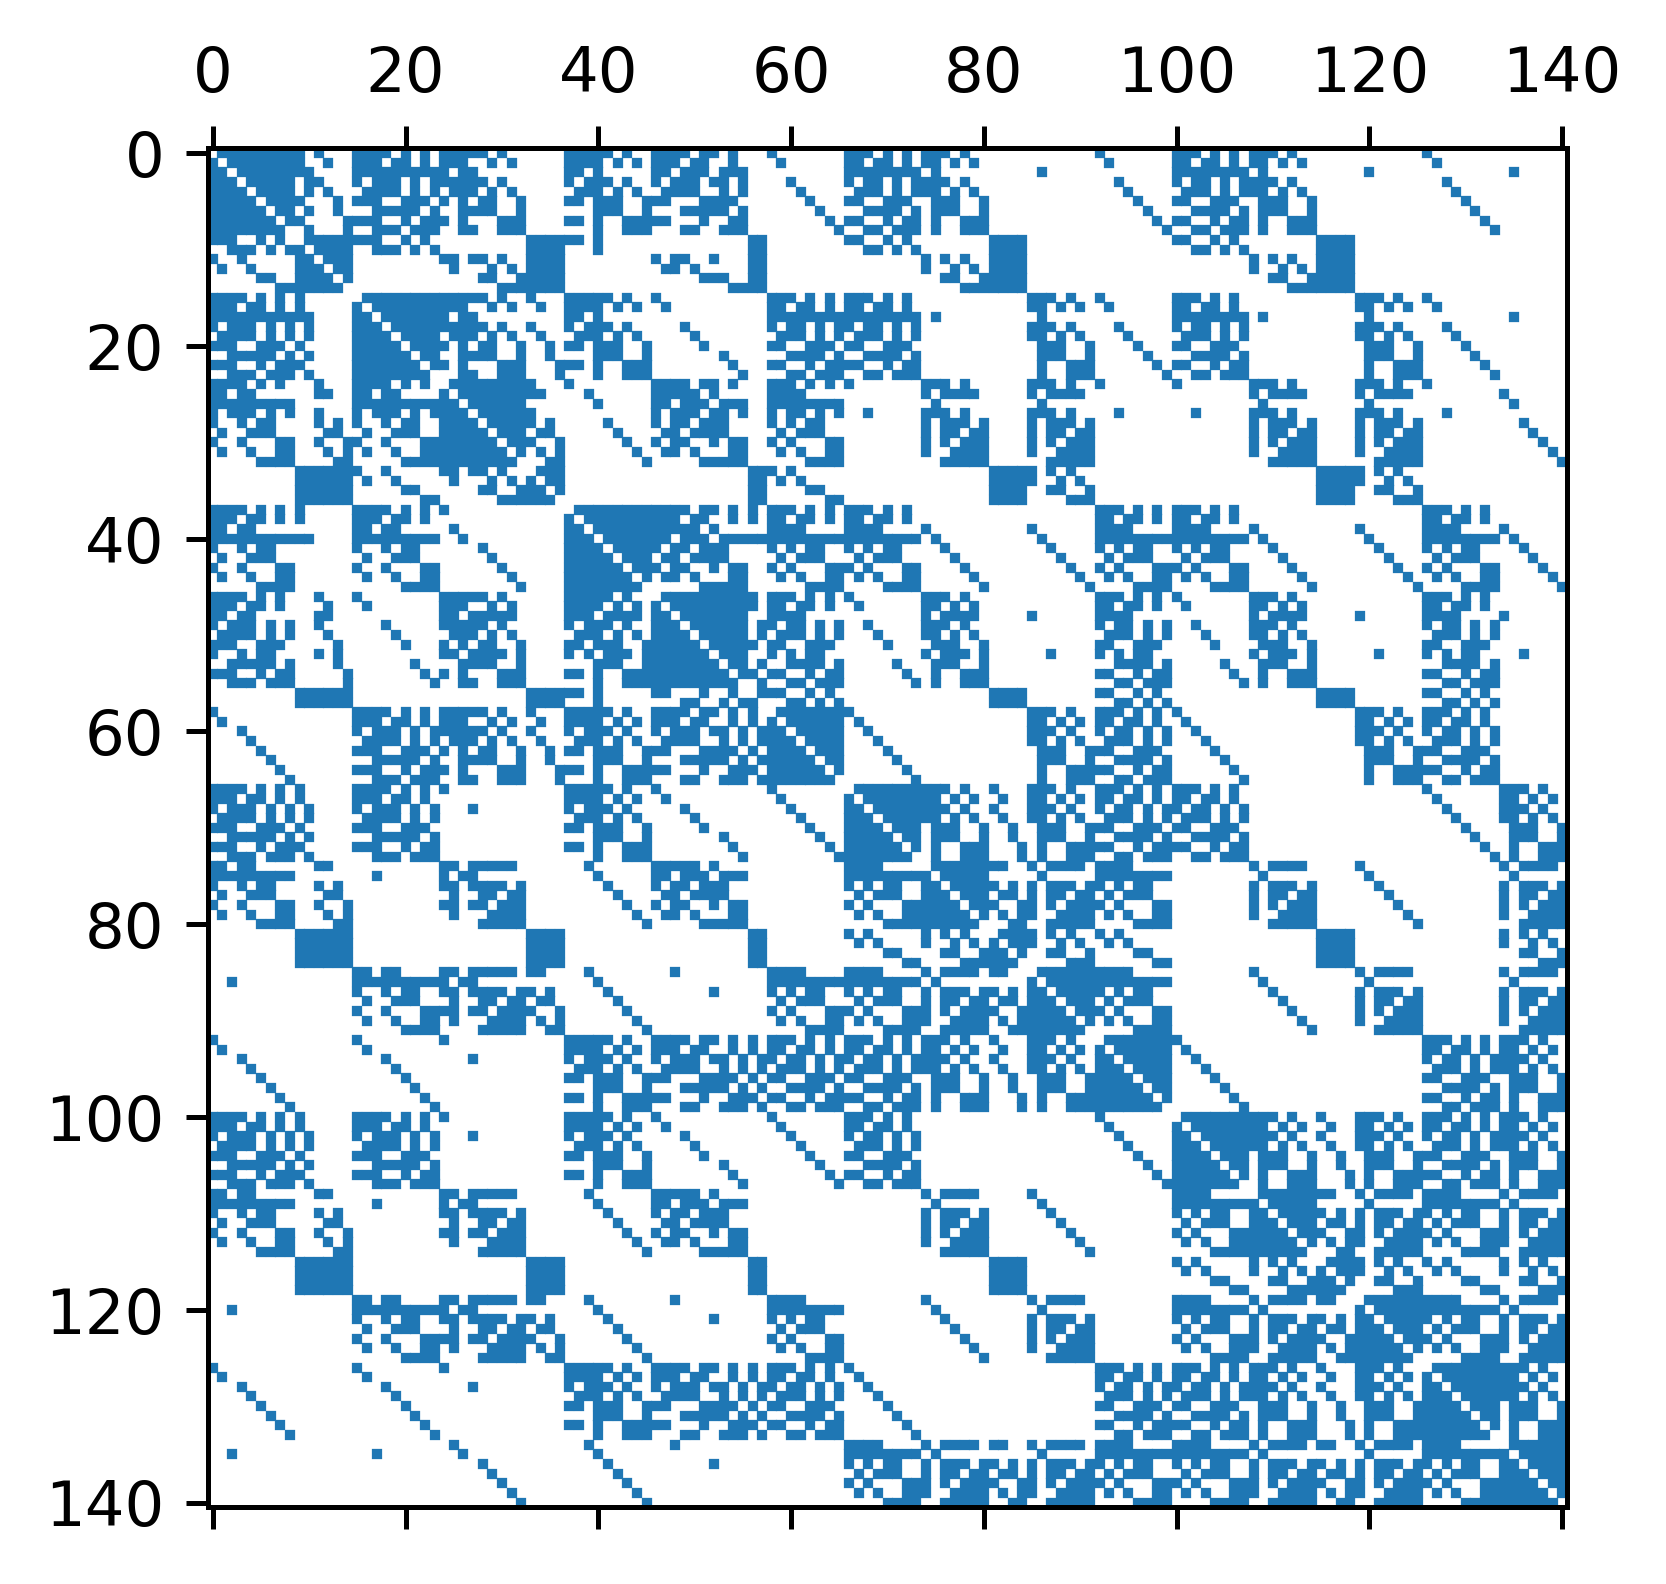

In [45]:
plt.clf()
figure = plt.figure(dpi=450)
axes = figure.add_subplot(111)
axes.spy(A[np.ix_(sg, sg)], markersize=0.5)
# y=A[np.ix_(sg, sg)]
# np.fill_diagonal(y, 0)
# caxes = axes.matshow(y, interpolation ='nearest',cmap="coolwarm")
# figure.colorbar(caxes)

 
plt.show()